In [417]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
import holidays
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import optuna
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Данные

In [283]:
df_movies = pd.read_csv('mkrf_movies.csv')
df_shows = pd.read_csv('mkrf_shows.csv')

# Обработка очистка 

In [284]:
df_movies

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,Сад художника: Американский импрессионизм,126008019,2019-12-23T12:00:00.000Z,Прочие,Севен Артс Продакшнз,Великобритания,Фил Грабски,Фил Грабски,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN
7482,Звериная ярость,121037819,2019-12-24T12:00:00.000Z,Художественный,"Дэниел Гродник Продакшнз, Вандерфилм Медиа Кор...",США,Ник Пауэлл,"Джефф Боулер, Дэниэл Гродник, Луильо Руис, Брэ...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.4,"боевик,триллер"
7483,Щенячий патруль: Скорей спешим на помощь!,124010819,2019-12-28T12:00:00.000Z,Художественный,"Никелодеон Анимейшн Студиос, Спин Мастер",США - Канада,Чарльз Е.Бастьен,Дженнифер Додж,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN
7484,"Машины песенки. Серия ""Испанские мотивы""",124010619,2019-12-30T12:00:00.000Z,Анимационный,"Анимаккорд Лтд., ООО Студия ""АНИМАККОРД""","Республика Кипр, Россия",А.Беляев,Д.Ловейко,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
df_shows

,puNumber,box_office
0,111000113,2.450000e+03
1,111000115,6.104000e+04
2,111000116,1.530300e+08
3,111000117,1.226096e+07
4,111000118,1.636841e+08
...,...,...
3153,224014814,1.530000e+03
3154,224021411,9.270000e+03
3155,224022410,4.000000e+02
3156,224023210,3.600000e+02


Обьединять данные будем по прокатному удостоверению, посмотрим сколько не уникальных значений

In [286]:
df_movies['puNumber'].duplicated().sum()

2

In [287]:
df_shows['puNumber'].duplicated().sum()

0

In [288]:
df_movies[df_movies['puNumber'].duplicated(keep=False)]['puNumber']

4638    221154310
4639    221154310
5067    221054410
5068    221054410
Name: puNumber, dtype: object

In [289]:
df_movies[df_movies['puNumber'].duplicated(keep=False)]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
4638,Как жениться и остаться холостым,221154310,2010-12-17T12:00:00.000Z,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия"
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17T12:00:00.000Z,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история"
5067,Анализируй это!,221054410,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал"
5068,Анализируй то!,221054410,2010-05-25T12:00:00.000Z,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал"


In [290]:
len(df_movies)

7486

In [291]:
len(df_shows)

3158

In [292]:
# Проверим типы данных в колонках puNumber
print("Тип данных puNumber в df_movies:", df_movies['puNumber'].dtype)
print("Тип данных puNumber в df_shows:", df_shows['puNumber'].dtype)

Тип данных puNumber в df_movies: object
Тип данных puNumber в df_shows: int64


In [293]:
df_movies.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   967
genres                    976
dtype: int64

In [294]:
df_shows.isna().sum()

puNumber      0
box_office    0
dtype: int64

In [295]:
# Найдем строки, где puNumber содержит нечисловые значения
non_numeric_movies = df_movies[~df_movies['puNumber'].apply(lambda x: str(x).replace('.', '').replace('-', '').isdigit())]
non_numeric_shows = df_shows[~df_shows['puNumber'].apply(lambda x: str(x).replace('.', '').replace('-', '').isdigit())]

print("НЕЧИСЛОВЫЕ ЗНАЧЕНИЯ В df_movies:")
print(f"Количество: {len(non_numeric_movies)}")
if len(non_numeric_movies) > 0:
    print("Уникальные значения:")
    print(non_numeric_movies['puNumber'].unique())
    print("\nПримеры строк:")
    print(non_numeric_movies[['puNumber']].head(10))

print("\n" + "="*50 + "\n")

print("НЕЧИСЛОВЫЕ ЗНАЧЕНИЯ В df_shows:")
print(f"Количество: {len(non_numeric_shows)}")
if len(non_numeric_shows) > 0:
    print("Уникальные значения:")
    print(non_numeric_shows['puNumber'].unique())
    print("\nПримеры строк:")
    print(non_numeric_shows[['puNumber', 'box_office']].head(10) if 'box_office' in df_shows.columns else non_numeric_shows.head(10))

НЕЧИСЛОВЫЕ ЗНАЧЕНИЯ В df_movies:
Количество: 2
Уникальные значения:
[' 111004112' 'нет']

Примеры строк:
        puNumber
804    111004112
1797         нет


НЕЧИСЛОВЫЕ ЗНАЧЕНИЯ В df_shows:
Количество: 0


In [296]:
# Приведем оба к одному типу (например, к string)
df_movies['puNumber'] = df_movies['puNumber'].astype(str)
df_shows['puNumber'] = df_shows['puNumber'].astype(str)

# Теперь объединим
merged_df = pd.merge(df_movies, df_shows, on='puNumber', how='left')

In [297]:
merged_df.head(15)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
5,Остановился поезд,111013816,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,драма,NaN
6,Любовь и голуби,111007013,2013-10-18T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.3,"мелодрама,комедия",2700.0
7,Любовь и сигареты,221074614,2014-12-29T12:00:00.000Z,Художественный,"Юнайтед Артистс, Грин Стрит Филмз, Айкон Интер...",США,Джон Туртурро,"Джон Пенотти, Джон Туртурро",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.6,"мюзикл,мелодрама,комедия",NaN
8,Отпетые мошенники.,121011416,2016-05-05T12:00:00.000Z,Художественный,"Пульсар Продюксьон, ТФ1 Фильм",Франция,Эрик Беснард,Патрис Леду,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,8.0,"комедия,криминал",NaN
9,Отпуск за свой счет,111019114,2014-12-01T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.8,"мелодрама,комедия",NaN


Столбец `puNumber` уже как будто смысла не несет, удалим его

In [298]:
merged_df_cleaned = merged_df.drop('puNumber', axis=1)

In [299]:
merged_df_cleaned.duplicated().sum()

5

In [300]:
merged_df_no_duplicates = merged_df_cleaned.drop_duplicates()

In [301]:
merged_df_no_duplicates.head(15)

,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
5,Остановился поезд,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,драма,NaN
6,Любовь и голуби,2013-10-18T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.3,"мелодрама,комедия",2700.0
7,Любовь и сигареты,2014-12-29T12:00:00.000Z,Художественный,"Юнайтед Артистс, Грин Стрит Филмз, Айкон Интер...",США,Джон Туртурро,"Джон Пенотти, Джон Туртурро",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.6,"мюзикл,мелодрама,комедия",NaN
8,Отпетые мошенники.,2016-05-05T12:00:00.000Z,Художественный,"Пульсар Продюксьон, ТФ1 Фильм",Франция,Эрик Беснард,Патрис Леду,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,8.0,"комедия,криминал",NaN
9,Отпуск за свой счет,2014-12-01T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.8,"мелодрама,комедия",NaN


In [302]:
merged_df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7481 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7481 non-null   object 
 1   show_start_date        7481 non-null   object 
 2   type                   7481 non-null   object 
 3   film_studio            7464 non-null   object 
 4   production_country     7479 non-null   object 
 5   director               7472 non-null   object 
 6   producer               6913 non-null   object 
 7   age_restriction        7481 non-null   object 
 8   refundable_support     332 non-null    float64
 9   nonrefundable_support  332 non-null    float64
 10  budget                 332 non-null    float64
 11  financing_source       332 non-null    object 
 12  ratings                6515 non-null   object 
 13  genres                 6506 non-null   object 
 14  box_office             3158 non-null   float64
dtypes: f

In [303]:
merged_df_no_duplicates.describe()

,refundable_support,nonrefundable_support,budget,box_office
count,3.320000e+02,3.320000e+02,3.320000e+02,3.158000e+03
mean,1.186446e+07,4.898099e+07,1.272297e+08,7.647870e+07
std,2.491656e+07,5.998012e+07,1.885883e+08,2.403531e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.500000e+07,4.200000e+07,8.623900e+04
50%,0.000000e+00,3.000000e+07,6.864992e+07,2.327988e+06
75%,1.500000e+07,4.037500e+07,1.419853e+08,2.397967e+07
max,1.800000e+08,4.000000e+08,2.305074e+09,3.073569e+09


In [304]:
merged_df_no_duplicates['type'].value_counts()

Художественный                4518
 Художественный               1388
Анимационный                   827
Прочие                         406
Документальный                 287
Научно-популярный               53
 Анимационный                    1
Музыкально-развлекательный       1
Name: type, dtype: int64

In [305]:
merged_df_no_duplicates['type'] = merged_df_no_duplicates['type'].str.strip().str.lower()

/tmp/ipykernel_47841/4220388708.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [306]:
merged_df_no_duplicates['type'].value_counts()

художественный                5906
анимационный                   828
прочие                         406
документальный                 287
научно-популярный               53
музыкально-развлекательный       1
Name: type, dtype: int64

In [307]:
merged_df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7481 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7481 non-null   object 
 1   show_start_date        7481 non-null   object 
 2   type                   7481 non-null   object 
 3   film_studio            7464 non-null   object 
 4   production_country     7479 non-null   object 
 5   director               7472 non-null   object 
 6   producer               6913 non-null   object 
 7   age_restriction        7481 non-null   object 
 8   refundable_support     332 non-null    float64
 9   nonrefundable_support  332 non-null    float64
 10  budget                 332 non-null    float64
 11  financing_source       332 non-null    object 
 12  ratings                6515 non-null   object 
 13  genres                 6506 non-null   object 
 14  box_office             3158 non-null   float64
dtypes: f

In [308]:
merged_df_no_duplicates['production_country'].value_counts()

США                                                                    2171
Россия                                                                 1819
СССР                                                                    347
Франция                                                                 301
Великобритания                                                          257
                                                                       ... 
Франция-Китай                                                             1
Россия, Германия, Великобритания                                          1
Великобритания - Италия - Испания                                         1
Россия-Ирландия                                                           1
Дания - Канада - Швеция - Франция - Германия - Великобритания - США       1
Name: production_country, Length: 950, dtype: int64

сначала почистим метки в колонке `production_country`

In [309]:
def clean_countries(country_str):
    # Если значение NaN — возвращаем NaN
    if pd.isna(country_str):
        return pd.NA  # или просто return country_str (оставит исходный NaN)
    
    
    # Преобразуем в строку и убираем лишние пробелы по краям
    country_str = str(country_str).strip()
    
    # Если после strip получилась пустая строка — возвращаем NaN
    if not country_str:
        return pd.NA
    
    # Приводим к нижнему регистру
    country_str = country_str.lower()
    
    # Заменяем дефисы, тире, подчёркивания и прочие разделители на запятую
    country_str = re.sub(r'[\-\—\–\_\|/]+', ',', country_str)
    
    # Нормализуем пробелы вокруг запятых: любые пробелы до/после запятой → одна запятая + один пробел
    country_str = re.sub(r'\s*,\s*', ', ', country_str)
    
    # Убираем дублирующиеся пробелы внутри названий стран
    country_str = re.sub(r'\s+', ' ', country_str)
    
    return country_str

# Применяем функцию к колонке 'production_country'
merged_df_no_duplicates['production_country'] = (
    merged_df_no_duplicates['production_country']
    .apply(clean_countries)
)


/tmp/ipykernel_47841/4193023508.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [310]:
merged_df_no_duplicates['production_country'].value_counts()

сша                                                              2174
россия                                                           1819
ссср                                                              377
франция                                                           302
великобритания                                                    259
                                                                 ... 
греция, россия                                                      1
великобритания, исландия, испания, швейцария, сша                   1
австралия, великобритания, бельгия, индия                           1
швеция, германия, франция, норвегия                                 1
дания, канада, швеция, франция, германия, великобритания, сша       1
Name: production_country, Length: 811, dtype: int64

In [311]:
merged_df_no_duplicates['production_country'].isna().sum()
# Удаляем строки с NaN в production_country
merged_df_no_duplicates = merged_df_no_duplicates.dropna(subset=['production_country'])

In [312]:
# Создаем признак соло-продакшен
# 1 если в production_country только одна страна, 0 если несколько

# Проверяем наличие запятых - если есть запятая, значит несколько стран
merged_df_no_duplicates['solo_production'] = merged_df_no_duplicates['production_country'].str.contains(',').astype(int)

# Инвертируем, чтобы 1 означало соло-продакшен
merged_df_no_duplicates['solo_production'] = 1 - merged_df_no_duplicates['solo_production']

создадим список стран отсортированнных по уровню кинопроизводства

In [313]:
# Экспертный список топ-50 стран по кинопроизводству
expert_countries_list_top50 = [
    "сша",
    "россия",
    "франция",
    "великобритания", 
    "германия",
    "италия",
    "индия",
    "япония",
    "южная корея",
    "китай",
    "канада",
    "испания",
    "австралия",
    "бразилия",
    "мексика",
    "турция",
    "польша",
    "нидерланды",
    "бельгия",
    "швеция",
    "дания",
    "норвегия",
    "финляндия",
    "швейцария",
    "австрия",
    "чехия",
    "венгрия",
    "румыния",
    "украина",
    "греция",
    "португалия",
    "ирландия",
    "израиль",
    "египет",
    "нигерия",
    "юар",
    "аргентина",
    "чили",
    "колумбия",
    "перу",
    "венесуэла",
    "куба",
    "тайвань",
    "гонконг",
    "сингапур",
    "малайзия",
    "индонезия",
    "таиланд",
    "филиппины",
    "вьетнам"
]

теперь мы смотрим на строки где solo_production = 0
и ищем в списке стран самую популярную по кинопроизводству (по списку expert_countries_list_top50) и оставляем только ее в production_country

In [314]:
# Функция для выбора самой популярной страны из списка
def get_most_popular_country(countries_string):
    # Разделяем строку на список стран
    countries_list = [country.strip() for country in countries_string.split(',')]
    
    # Ищем первую страну из нашего экспертного списка
    for country in expert_countries_list_top50:
        if country in countries_list:
            return country
    
    # Если ни одной страны из топа-50 не найдено, возвращаем первую страну из списка
    return countries_list[0] if countries_list else None

# Применяем функцию к совместным продакшенам
print("Обновляем страны для совместных продакшенов...")
merged_df_no_duplicates.loc[merged_df_no_duplicates['solo_production'] == 0, 'production_country'] = merged_df_no_duplicates.loc[
    merged_df_no_duplicates['solo_production'] == 0, 'production_country'
].apply(get_most_popular_country)

Обновляем страны для совместных продакшенов...


In [315]:
merged_df_no_duplicates['genres'].value_counts()

драма                           476
комедия                         352
мелодрама,комедия               222
драма,мелодрама,комедия         189
драма,мелодрама                 183
                               ... 
документальный,новости,драма      1
семейный,детектив,детский         1
комедия,история,драма             1
для взрослых,драма,комедия        1
мелодрама,история,драма           1
Name: genres, Length: 742, dtype: int64

In [316]:
merged_df_no_duplicates['age_restriction'].value_counts()

«16+» - для детей старше 16 лет           2847
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1592
«0+» - для любой зрительской аудитории     809
«6+» - для детей старше 6 лет              626
Name: age_restriction, dtype: int64

In [317]:
merged_df_no_duplicates.head()

,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,solo_production
0,Открытый простор,2015-11-27T12:00:00.000Z,художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",сша,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN,1
1,Особо важное задание,2016-09-13T12:00:00.000Z,художественный,"Киностудия ""Мосфильм""",ссср,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN,1
2,Особо опасен,2016-10-10T12:00:00.000Z,художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",сша,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,1
3,Особо опасен,2016-06-10T12:00:00.000Z,художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",сша,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,1
4,Особо опасен,2015-07-29T12:00:00.000Z,художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",сша,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,1


Удалим дубликаты отличающиеся только датой

In [318]:
merged_df_no_duplicates.columns

Index(['title', 'show_start_date', 'type', 'film_studio', 'production_country',
       'director', 'producer', 'age_restriction', 'refundable_support',
       'nonrefundable_support', 'budget', 'financing_source', 'ratings',
       'genres', 'box_office', 'solo_production'],
      dtype='object')

In [319]:
cols_to_check = ['title', 'type', 'film_studio', 'production_country',
       'director', 'producer', 'age_restriction', 'refundable_support',
       'nonrefundable_support', 'budget', 'financing_source', 'ratings',
       'genres', 'box_office', 'solo_production']

In [320]:
merged_df_no_duplicates_date = merged_df_no_duplicates.drop_duplicates(
    subset=cols_to_check,
    keep='first'
)

In [321]:
merged_df_no_duplicates_date.head()

,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,solo_production
0,Открытый простор,2015-11-27T12:00:00.000Z,художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",сша,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN,1
1,Особо важное задание,2016-09-13T12:00:00.000Z,художественный,"Киностудия ""Мосфильм""",ссср,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN,1
2,Особо опасен,2016-10-10T12:00:00.000Z,художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",сша,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,1
5,Остановился поезд,2016-09-13T12:00:00.000Z,художественный,"Киностудия ""Мосфильм""",ссср,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,драма,NaN,1
6,Любовь и голуби,2013-10-18T12:00:00.000Z,художественный,"Киностудия ""Мосфильм""",ссср,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.3,"мелодрама,комедия",2700.0,1


Сделаем one‑hot кодирование для столбца 'type'

In [322]:

# Выполняем one‑hot кодирование для столбца 'type'
type_dummies = pd.get_dummies(
    merged_df_no_duplicates_date['type'],
    prefix='type'  # префикс для новых столбцов
)

# Объединяем исходные данные с закодированными столбцами
df_encoded = pd.concat([merged_df_no_duplicates_date, type_dummies], axis=1)

# Удаляем исходный столбец 'type', так как он теперь представлен в закодированном виде
df_encoded = df_encoded.drop('type', axis=1)

In [323]:
df_encoded.head()

,title,show_start_date,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,...,ratings,genres,box_office,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный
0,Открытый простор,2015-11-27T12:00:00.000Z,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",сша,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,...,7.2,"боевик,драма,мелодрама",NaN,1,0,0,0,0,0,1
1,Особо важное задание,2016-09-13T12:00:00.000Z,"Киностудия ""Мосфильм""",ссср,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,...,6.6,"драма,военный",NaN,1,0,0,0,0,0,1
2,Особо опасен,2016-10-10T12:00:00.000Z,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",сша,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,...,6.8,"фантастика,боевик,триллер",NaN,1,0,0,0,0,0,1
5,Остановился поезд,2016-09-13T12:00:00.000Z,"Киностудия ""Мосфильм""",ссср,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,...,7.7,драма,NaN,1,0,0,0,0,0,1
6,Любовь и голуби,2013-10-18T12:00:00.000Z,"Киностудия ""Мосфильм""",ссср,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,...,8.3,"мелодрама,комедия",2700.0,1,0,0,0,0,0,1


In [324]:
df_encoded['production_country'].value_counts()

сша                      2674
россия                   1949
франция                   641
ссср                      385
великобритания            318
                         ... 
республика узбекистан       1
норвения                    1
чили                        1
чехословакия                1
пакистан                    1
Name: production_country, Length: 73, dtype: int64

In [325]:
# Получаем частоты стран
country_counts = df_encoded['production_country'].value_counts()
print(f"Всего уникальных стран: {len(country_counts)}")

# Создаем список стран в порядке убывания частоты (от самой частой к самой редкой)
countries_ordered = country_counts.index.tolist()

# Создаем обратный порядок кодирования: самая частая страна (США) получает наибольший код
# Если всего 73 уникальных страны, то США получит код 72, Россия 71, и т.д.
encoding_mapping = {country: len(countries_ordered) - 1 - idx for idx, country in enumerate(countries_ordered)}

# Применяем кодирование
df_encoded['production_country_encoded'] = df_encoded['production_country'].map(encoding_mapping)

print("Кодирование завершено!")
print(f"Диапазон кодов: от {df_encoded['production_country_encoded'].min()} до {df_encoded['production_country_encoded'].max()}")

# Проверим результат на топ-20 стран
print("\nТоп-20 стран и их коды:")
top_20_countries = country_counts.head(20)
for country, count in top_20_countries.items():
    code = encoding_mapping[country]
    print(f"{country:20} | Частота: {count:4d} | Код: {code:2d}")

# Проверим что все значения закодированы корректно
print(f"\nПроверка:")
print(f"Уникальных кодов: {df_encoded['production_country_encoded'].nunique()}")
print(f"Пропущенных значений: {df_encoded['production_country_encoded'].isna().sum()}")

Всего уникальных стран: 73
Кодирование завершено!
Диапазон кодов: от 0 до 72

Топ-20 стран и их коды:
сша                  | Частота: 2674 | Код: 72
россия               | Частота: 1949 | Код: 71
франция              | Частота:  641 | Код: 70
ссср                 | Частота:  385 | Код: 69
великобритания       | Частота:  318 | Код: 68
германия             | Частота:  165 | Код: 67
италия               | Частота:  142 | Код: 66
испания              | Частота:   90 | Код: 65
япония               | Частота:   83 | Код: 64
канада               | Частота:   65 | Код: 63
австралия            | Частота:   51 | Код: 62
швеция               | Частота:   38 | Код: 61
кнр                  | Частота:   31 | Код: 60
республика кипр      | Частота:   31 | Код: 59
южная корея          | Частота:   29 | Код: 58
индия                | Частота:   25 | Код: 57
дания                | Частота:   20 | Код: 56
норвегия             | Частота:   19 | Код: 55
нидерланды           | Частота:   17 | Код: 54
мекси

In [326]:
df_encoded = df_encoded.drop('production_country', axis=1)

In [327]:
df_encoded.head(30)

,title,show_start_date,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,...,genres,box_office,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,production_country_encoded
0,Открытый простор,2015-11-27T12:00:00.000Z,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,"боевик,драма,мелодрама",NaN,1,0,0,0,0,0,1,72
1,Особо важное задание,2016-09-13T12:00:00.000Z,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,"драма,военный",NaN,1,0,0,0,0,0,1,69
2,Особо опасен,2016-10-10T12:00:00.000Z,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,"фантастика,боевик,триллер",NaN,1,0,0,0,0,0,1,72
5,Остановился поезд,2016-09-13T12:00:00.000Z,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,драма,NaN,1,0,0,0,0,0,1,69
6,Любовь и голуби,2013-10-18T12:00:00.000Z,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,"мелодрама,комедия",2700.0,1,0,0,0,0,0,1,69
7,Любовь и сигареты,2014-12-29T12:00:00.000Z,"Юнайтед Артистс, Грин Стрит Филмз, Айкон Интер...",Джон Туртурро,"Джон Пенотти, Джон Туртурро",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,"мюзикл,мелодрама,комедия",NaN,1,0,0,0,0,0,1,72
8,Отпетые мошенники.,2016-05-05T12:00:00.000Z,"Пульсар Продюксьон, ТФ1 Фильм",Эрик Беснард,Патрис Леду,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,"комедия,криминал",NaN,1,0,0,0,0,0,1,70
9,Отпуск за свой счет,2014-12-01T12:00:00.000Z,"Киностудия ""Мосфильм"", Телевидение ВНР",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,"мелодрама,комедия",NaN,0,0,0,0,0,0,1,46
10,Превосходство Борна /По одноименной новелле Ро...,2016-06-29T12:00:00.000Z,"Кеннеди/Маршал Компани, Юниверсал Пикчерз, Гип...",Пол Грингросс,"Патрик Кроули, Фрэнк Маршалл, Пол Сэндберг",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,...,"боевик,триллер,детектив",NaN,1,0,0,0,0,0,1,72
11,Ответный ход,2014-12-01T12:00:00.000Z,"Киностудия ""Мосфильм""",М.Туманишвили,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,"боевик,драма,приключения",NaN,1,0,0,0,0,0,1,69


In [328]:
df_encoded['show_start_date'].dtype

dtype('O')

In [329]:
df_encoded['show_start_date'] = df_encoded['show_start_date'].str.split('T').str[0]
df_encoded['show_start_date'].head(10)

0     2015-11-27
1     2016-09-13
2     2016-10-10
5     2016-09-13
6     2013-10-18
7     2014-12-29
8     2016-05-05
9     2014-12-01
10    2016-06-29
11    2014-12-01
Name: show_start_date, dtype: object

In [330]:
df_encoded['show_start_date'] = pd.to_datetime(df_encoded['show_start_date'], errors='coerce')
df_encoded['show_start_date'].head(10)

0    2015-11-27
1    2016-09-13
2    2016-10-10
5    2016-09-13
6    2013-10-18
7    2014-12-29
8    2016-05-05
9    2014-12-01
10   2016-06-29
11   2014-12-01
Name: show_start_date, dtype: datetime64[ns]

In [331]:
df_encoded['show_start_date'].dtype

dtype('<M8[ns]')

In [332]:
# Создаем объект с российскими праздниками
ru_holidays = holidays.Russia()

# Извлекаем временные признаки
df_encoded['year'] = df_encoded['show_start_date'].dt.year
df_encoded['month'] = df_encoded['show_start_date'].dt.month
df_encoded['day'] = df_encoded['show_start_date'].dt.day
df_encoded['day_of_week'] = df_encoded['show_start_date'].dt.dayofweek  # 0-понедельник, 6-воскресенье
df_encoded['is_weekend'] = (df_encoded['day_of_week'] >= 5).astype(int)

# Признак праздников
df_encoded['is_holiday'] = df_encoded['show_start_date'].apply(lambda x: x in ru_holidays).astype(int)

# Признак дня перед праздником
df_encoded['day_before_holiday'] = df_encoded['show_start_date'].apply(
    lambda x: (x + pd.Timedelta(days=1)) in ru_holidays
).astype(int)

# Сезонность
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

df_encoded['season'] = df_encoded['month'].apply(get_season)

In [333]:
df_encoded.head()

,title,show_start_date,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,...,type_художественный,production_country_encoded,year,month,day,day_of_week,is_weekend,is_holiday,day_before_holiday,season
0,Открытый простор,2015-11-27,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,1,72,2015,11,27,4,0,0,0,autumn
1,Особо важное задание,2016-09-13,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,1,69,2016,9,13,1,0,0,0,autumn
2,Особо опасен,2016-10-10,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,1,72,2016,10,10,0,0,0,0,autumn
5,Остановился поезд,2016-09-13,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,1,69,2016,9,13,1,0,0,0,autumn
6,Любовь и голуби,2013-10-18,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,1,69,2013,10,18,4,0,0,0,autumn


In [334]:
# Создаем one-hot encoding для сезонов
season_dummies = pd.get_dummies(df_encoded['season'], prefix='season')

# Добавляем one-hot колонки к основному датафрейму
df_encoded = pd.concat([df_encoded, season_dummies], axis=1)

df_encoded = df_encoded.drop('season', axis=1)

In [335]:
print(len(df_encoded))
df_encoded.head()

7000


,title,show_start_date,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,...,month,day,day_of_week,is_weekend,is_holiday,day_before_holiday,season_autumn,season_spring,season_summer,season_winter
0,Открытый простор,2015-11-27,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,11,27,4,0,0,0,1,0,0,0
1,Особо важное задание,2016-09-13,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,9,13,1,0,0,0,1,0,0,0
2,Особо опасен,2016-10-10,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,10,10,0,0,0,0,1,0,0,0
5,Остановился поезд,2016-09-13,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,9,13,1,0,0,0,1,0,0,0
6,Любовь и голуби,2013-10-18,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,10,18,4,0,0,0,1,0,0,0


In [336]:
df_encoded

,title,show_start_date,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,...,month,day,day_of_week,is_weekend,is_holiday,day_before_holiday,season_autumn,season_spring,season_summer,season_winter
0,Открытый простор,2015-11-27,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,11,27,4,0,0,0,1,0,0,0
1,Особо важное задание,2016-09-13,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,9,13,1,0,0,0,1,0,0,0
2,Особо опасен,2016-10-10,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,10,10,0,0,0,0,1,0,0,0
5,Остановился поезд,2016-09-13,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,9,13,1,0,0,0,1,0,0,0
6,Любовь и голуби,2013-10-18,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,10,18,4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,Сад художника: Американский импрессионизм,2019-12-23,Севен Артс Продакшнз,Фил Грабски,Фил Грабски,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,12,23,0,0,0,0,0,0,0,1
7482,Звериная ярость,2019-12-24,"Дэниел Гродник Продакшнз, Вандерфилм Медиа Кор...",Ник Пауэлл,"Джефф Боулер, Дэниэл Гродник, Луильо Руис, Брэ...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,...,12,24,1,0,0,0,0,0,0,1
7483,Щенячий патруль: Скорей спешим на помощь!,2019-12-28,"Никелодеон Анимейшн Студиос, Спин Мастер",Чарльз Е.Бастьен,Дженнифер Додж,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,...,12,28,5,1,0,0,0,0,0,1
7484,"Машины песенки. Серия ""Испанские мотивы""",2019-12-30,"Анимаккорд Лтд., ООО Студия ""АНИМАККОРД""",А.Беляев,Д.Ловейко,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,...,12,30,0,0,0,0,0,0,0,1


In [337]:
# Удаляем строки с NaN в genres
df_encoded = df_encoded.dropna(subset=['genres'])
print(len(df_encoded))

6029


In [338]:
df_encoded['genres'].head(100)

0         боевик,драма,мелодрама
1                  драма,военный
2      фантастика,боевик,триллер
5                          драма
6              мелодрама,комедия
                 ...            
99       военный,биография,драма
100              драма,мелодрама
101                        драма
102       триллер,драма,криминал
103         боевик,триллер,драма
Name: genres, Length: 100, dtype: object

In [339]:
# Экспертный список основных жанров кино
expert_genres_list_extended = [
    "драма",
    "комедия", 
    "боевик",
    "триллер",
    "мелодрама",
    "приключения",
    "фантастика",
    "фэнтези",
    "ужасы",
    "детектив",
    "криминал",
    "исторический",
    "биография",
    "военный",
    "вестерн",
    "мультфильм",
    "семейный",
    "детский",
    "мюзикл",
    "документальный",
    "спорт",
    "аниме",
    "короткометражный",
    "фильм-нуар",
    "арт-хаус",
    "история",
    "короткометражка",
    "музыка",
    "концерт",
    "новости",
    "реальноетв",
    "длявзрослых",
    "неизвестный"
]

len(expert_genres_list_extended)

33

In [340]:
# Приводим к нижнему регистру и удаляем пробелы
df_encoded['genres_clean'] = df_encoded['genres'].str.lower().str.replace(' ', '')

# Разделяем жанры по запятой и создаем список всех уникальных жанров
all_genres = df_encoded['genres_clean'].str.split(',').explode().unique()

# Сортируем список уникальных жанров
unique_genres_sorted = sorted(all_genres)

print(f"Всего уникальных жанров: {len(unique_genres_sorted)}")
print("\nСписок уникальных жанров:")
for i, genre in enumerate(unique_genres_sorted, 1):
    print(f"{i:2d}. {genre}")

# Сохраняем список
unique_genres_list = unique_genres_sorted
print(unique_genres_list)

Всего уникальных жанров: 29

Список уникальных жанров:
 1. аниме
 2. биография
 3. боевик
 4. вестерн
 5. военный
 6. детектив
 7. детский
 8. длявзрослых
 9. документальный
10. драма
11. история
12. комедия
13. концерт
14. короткометражка
15. криминал
16. мелодрама
17. музыка
18. мультфильм
19. мюзикл
20. новости
21. приключения
22. реальноетв
23. семейный
24. спорт
25. триллер
26. ужасы
27. фантастика
28. фильм-нуар
29. фэнтези
['аниме', 'биография', 'боевик', 'вестерн', 'военный', 'детектив', 'детский', 'длявзрослых', 'документальный', 'драма', 'история', 'комедия', 'концерт', 'короткометражка', 'криминал', 'мелодрама', 'музыка', 'мультфильм', 'мюзикл', 'новости', 'приключения', 'реальноетв', 'семейный', 'спорт', 'триллер', 'ужасы', 'фантастика', 'фильм-нуар', 'фэнтези']


/tmp/ipykernel_47841/4158717043.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [341]:
df_encoded['genres_clean'].head()

0       боевик,драма,мелодрама
1                драма,военный
2    фантастика,боевик,триллер
5                        драма
6            мелодрама,комедия
Name: genres_clean, dtype: object

Ван хот для жанров

In [342]:
genre_columns = []

for genre in expert_genres_list_extended:
    if genre == "неизвестный":
        continue
        
    col_name = f'genre_{genre}'
    df_encoded[col_name] = df_encoded['genres_clean'].str.contains(genre, regex=False).astype(int)
    genre_columns.append(col_name)

# Признак для неизвестных жанров
df_encoded['genre_неизвестный'] = (df_encoded[genre_columns].sum(axis=1) == 0).astype(int)

print(f"Создано признаков жанров: {len(genre_columns) + 1}")

Создано признаков жанров: 33


/tmp/ipykernel_47841/1914987212.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_47841/1914987212.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_47841/1914987212.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4

In [343]:
df_encoded.head()

,title,show_start_date,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,...,genre_фильм-нуар,genre_арт-хаус,genre_история,genre_короткометражка,genre_музыка,genre_концерт,genre_новости,genre_реальноетв,genre_длявзрослых,genre_неизвестный
0,Открытый простор,2015-11-27,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,Особо важное задание,2016-09-13,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,Особо опасен,2016-10-10,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,Остановился поезд,2016-09-13,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,Любовь и голуби,2013-10-18,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [344]:
df_encoded = df_encoded.drop(['genres', 'genres_clean'], axis=1)

In [345]:
df_encoded.head()

,title,show_start_date,film_studio,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,...,genre_фильм-нуар,genre_арт-хаус,genre_история,genre_короткометражка,genre_музыка,genre_концерт,genre_новости,genre_реальноетв,genre_длявзрослых,genre_неизвестный
0,Открытый простор,2015-11-27,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,Особо важное задание,2016-09-13,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,Особо опасен,2016-10-10,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,Остановился поезд,2016-09-13,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,Любовь и голуби,2013-10-18,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [346]:
df_encoded.columns

Index(['title', 'show_start_date', 'film_studio', 'director', 'producer',
       'age_restriction', 'refundable_support', 'nonrefundable_support',
       'budget', 'financing_source', 'ratings', 'box_office',
       'solo_production', 'type_анимационный', 'type_документальный',
       'type_музыкально-развлекательный', 'type_научно-популярный',
       'type_прочие', 'type_художественный', 'production_country_encoded',
       'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_holiday',
       'day_before_holiday', 'season_autumn', 'season_spring', 'season_summer',
       'season_winter', 'genre_драма', 'genre_комедия', 'genre_боевик',
       'genre_триллер', 'genre_мелодрама', 'genre_приключения',
       'genre_фантастика', 'genre_фэнтези', 'genre_ужасы', 'genre_детектив',
       'genre_криминал', 'genre_исторический', 'genre_биография',
       'genre_военный', 'genre_вестерн', 'genre_мультфильм', 'genre_семейный',
       'genre_детский', 'genre_мюзикл', 'genre_документальный', 'g

In [347]:
df_encoded = df_encoded.drop(['refundable_support', 'nonrefundable_support', 'budget', 'financing_source'], axis=1)

In [348]:
df_encoded.head()

,title,show_start_date,film_studio,director,producer,age_restriction,ratings,box_office,solo_production,type_анимационный,...,genre_фильм-нуар,genre_арт-хаус,genre_история,genre_короткометражка,genre_музыка,genre_концерт,genre_новости,genre_реальноетв,genre_длявзрослых,genre_неизвестный
0,Открытый простор,2015-11-27,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.2,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Особо важное задание,2016-09-13,"Киностудия ""Мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,6.6,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Особо опасен,2016-10-10,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.8,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
5,Остановился поезд,2016-09-13,"Киностудия ""Мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,7.7,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
6,Любовь и голуби,2013-10-18,"Киностудия ""Мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,8.3,2700.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
# Приводим film_studio к нижнему регистру и очищаем пробелы
df_encoded['film_studio'] = df_encoded['film_studio'].str.lower().str.strip().str.replace(r'\s+', ' ', regex=True)

# Разделяем студии по запятой и создаем список всех студий
all_studios = df_encoded['film_studio'].str.split(',').explode()

# Очищаем каждую студию от пробелов
all_studios_clean = all_studios.str.strip()

# Считаем топ-10 студий
top_studios = all_studios_clean.value_counts().head(50)

print("Топ-50 студий (с учетом разделения через запятую):")
for i, (studio, count) in enumerate(top_studios.items(), 1):
    print(f"{i:2d}. {studio}: {count} фильмов")

Топ-50 студий (с учетом разделения через запятую):
 1. киностудия "мосфильм": 352 фильмов
 2. уорнер бразерс: 323 фильмов
 3. канал +: 222 фильмов
 4. юниверсал пикчерз: 176 фильмов
 5. сине +: 136 фильмов
 6. хх век фокс: 121 фильмов
 7. парамаунт пикчерз: 106 фильмов
 8. франс телевизьон: 88 фильмов
 9. коламбиа пикчерз: 88 фильмов
10. нью лайн синема: 86 фильмов
11. франс 2 синема: 83 фильмов
12. уолт дисней пикчерз: 82 фильмов
13. национальный центр кинематографии: 80 фильмов
14. франс 3 синема: 56 фильмов
15. студио канал: 53 фильмов
16. виллидж роадшоу пикчерз: 49 фильмов
17. гомон: 48 фильмов
18. метро голдвин майер: 47 фильмов
19. саммит интертейнмент: 45 фильмов
20. миллениум филмз: 39 фильмов
21. тачстоун пикчерз: 37 фильмов
22. уалд банч: 36 фильмов
23. скоуп пикчерз: 32 фильмов
24. би-би-си: 32 фильмов
25. патэ: 31 фильмов
26. леджендари пикчерз: 31 фильмов
27. филм и васт: 31 фильмов
28. мирамакс: 29 фильмов
29. уайлд банч: 29 фильмов
30. арт франс синема: 27 фильмов
31. к

In [350]:
# Создаем список топ-50 студий
top_studios_list = [
    'киностудия "мосфильм"',
    'уорнер бразерс',
    'канал +',
    'юниверсал пикчерз',
    'сине +',
    'хх век фокс',
    'парамаунт пикчерз',
    'франс телевизьон',
    'коламбиа пикчерз',
    'нью лайн синема',
    'франс 2 синема',
    'уолт дисней пикчерз',
    'национальный центр кинематографии',
    'франс 3 синема',
    'студио канал',
    'виллидж роадшоу пикчерз',
    'гомон',
    'метро голдвин майер',
    'саммит интертейнмент',
    'миллениум филмз',
    'тачстоун пикчерз',
    'уалд банч',
    'скоуп пикчерз',
    'би-би-си',
    'патэ',
    'леджендари пикчерз',
    'филм и васт',
    'мирамакс',
    'уайлд банч',
    'арт франс синема',
    'канал+',
    'релативити медиа',
    'ориджинал филм',
    'скотт фри продакшнз',
    'дримуоркс пикчерз',
    'лайонсгейт',
    'буена виста интернэшнл',
    'филм фо',
    'синесинема',
    'сони пикчерз интертейнмент',
    'ооо "таббак"',
    'ооо "студия анимационного кино "мельница"',
    'тэ эс гэ интертейнмент',
    'тф1 фильм продюксьон',
    'фокс 2000 пикчерз',
    'просиреп',
    'дримуоркс анимейшн',
    'рилейтивити медиа',
    'уоркинг тайтл филмз',
    'партисипант медиа'
]

# Сначала проверим и обработаем пропуски в film_studio
na_count = df_encoded['film_studio'].isna().sum()
print(f"Пропуски в film_studio: {na_count}")

# Заполним пропуски пустой строкой
df_encoded['film_studio'] = df_encoded['film_studio'].fillna('')

# Создаем one-hot encoding для студий
for studio in top_studios_list:
    # Создаем признак: 1 если студия участвовала в съемках, 0 если нет
    df_encoded[f'studio_{studio}'] = df_encoded['film_studio'].str.contains(studio, regex=False).astype(int)

# Создаем признак "иное" - 1 если ни одна студия из списка не участвовала
studio_columns = [f'studio_{studio}' for studio in top_studios_list]
df_encoded['studio_иное'] = (df_encoded[studio_columns].sum(axis=1) == 0).astype(int)

Пропуски в film_studio: 4


In [351]:
df_encoded.head()

,title,show_start_date,film_studio,director,producer,age_restriction,ratings,box_office,solo_production,type_анимационный,...,"studio_ооо ""студия анимационного кино ""мельница""",studio_тэ эс гэ интертейнмент,studio_тф1 фильм продюксьон,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное
0,Открытый простор,2015-11-27,"тачстоун пикчерз, кобальт пикчерз, бикон пикче...",Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.2,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Особо важное задание,2016-09-13,"киностудия ""мосфильм""",Е.Матвеев,NaN,«6+» - для детей старше 6 лет,6.6,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Особо опасен,2016-10-10,"юниверсал пикчерз, кикстарт продакшнз, марк пл...",Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.8,NaN,1,0,...,0,0,0,0,0,0,1,0,0,0
5,Остановился поезд,2016-09-13,"киностудия ""мосфильм""",В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,7.7,NaN,1,0,...,0,0,0,0,0,0,0,0,0,0
6,Любовь и голуби,2013-10-18,"киностудия ""мосфильм""",В.Меньшов,NaN,«12+» - для детей старше 12 лет,8.3,2700.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [352]:
df_encoded = df_encoded.drop(['film_studio','show_start_date', 'title'], axis=1)

In [353]:
df_encoded.head()

,director,producer,age_restriction,ratings,box_office,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,...,"studio_ооо ""студия анимационного кино ""мельница""",studio_тэ эс гэ интертейнмент,studio_тф1 фильм продюксьон,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное
0,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.2,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,6.6,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.8,NaN,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,7.7,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,В.Меньшов,NaN,«12+» - для детей старше 12 лет,8.3,2700.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [354]:
df_encoded = df_encoded.drop(['box_office'], axis=1)

In [355]:
df_encoded.head()

,director,producer,age_restriction,ratings,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,...,"studio_ооо ""студия анимационного кино ""мельница""",studio_тэ эс гэ интертейнмент,studio_тф1 фильм продюксьон,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное
0,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,7.2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,6.6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,6.8,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,7.7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,В.Меньшов,NaN,«12+» - для детей старше 12 лет,8.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [356]:
# Приводим age_restriction к нижнему регистру и очищаем от спецсимволов
df_encoded['age_restriction'] = df_encoded['age_restriction'].str.lower().str.strip()

# Удаляем все не буквенно-цифровые символы, оставляем только цифры и знак +
df_encoded['age_restriction'] = df_encoded['age_restriction'].str.replace(r'[^\w\+]', '', regex=True)

# Удаляем лишние пробелы (если остались)
df_encoded['age_restriction'] = df_encoded['age_restriction'].str.replace(r'\s+', '', regex=True)

In [357]:
age_counts = df_encoded['age_restriction'].value_counts()

print(age_counts)

16+длядетейстарше16лет            2398
18+запрещенодлядетей              1389
12+длядетейстарше12лет            1278
6+длядетейстарше6лет               524
0+длялюбойзрительскойаудитории     440
Name: age_restriction, dtype: int64


In [358]:
# Отсортируем рейтинги по возрасту в порядке убывания
age_order = sorted(age_counts.index, reverse=True)  # от большего к меньшему

# Создаем маппинг для кодирования
age_mapping = {age: idx for idx, age in enumerate(age_order)}

# Применяем кодирование
df_encoded['age_restriction_encoded'] = df_encoded['age_restriction'].map(age_mapping)


In [359]:
df_encoded = df_encoded.drop(['age_restriction'], axis=1)

In [360]:
df_encoded.head()

,director,producer,ratings,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,...,studio_тэ эс гэ интертейнмент,studio_тф1 фильм продюксьон,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное,age_restriction_encoded
0,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",7.2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,Е.Матвеев,NaN,6.6,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",6.8,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
5,В.Абдрашитов,NaN,7.7,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,В.Меньшов,NaN,8.3,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3


In [361]:
df_encoded['director'].isna().sum()

2

In [362]:
df_encoded['director'].head(10)

0         Кевин Костнер
1             Е.Матвеев
2     Тимур Бекмамбетов
5          В.Абдрашитов
6             В.Меньшов
7         Джон Туртурро
8          Эрик Беснард
9               В.Титов
10        Пол Грингросс
11        М.Туманишвили
Name: director, dtype: object

In [363]:
df_encoded['director'].value_counts()

Вуди Аллен          13
Ридли Скотт         12
Стивен Содерберг    12
Стивен Спилберг     10
Люк Бессон          10
                    ..
Ник Саймон           1
Норберт Хайткер      1
И.Перекатов          1
Р.Ильясов            1
И.Трусов             1
Name: director, Length: 4143, dtype: int64

In [364]:
# Альтернатива: более агрессивная очистка (только буквы и пробелы)
df_encoded['director_clean'] = df_encoded['director'].str.lower().str.strip()
df_encoded['director_clean'] = df_encoded['director_clean'].str.replace(r'[^a-zа-яё\s]', '', regex=True)
df_encoded['director_clean'] = df_encoded['director_clean'].str.replace(r'\s+', ' ', regex=True).str.strip()

print("\nАгрессивная очистка (только буквы и пробелы):")
print(df_encoded['director_clean'].head(10))
print(f"Уникальных режиссеров после агрессивной очистки: {df_encoded['director_clean'].nunique()}")


Агрессивная очистка (только буквы и пробелы):
0         кевин костнер
1              ематвеев
2     тимур бекмамбетов
5           вабдрашитов
6              вменьшов
7         джон туртурро
8          эрик беснард
9                втитов
10        пол грингросс
11         мтуманишвили
Name: director_clean, dtype: object
Уникальных режиссеров после агрессивной очистки: 4125


Много уникальных значений, для ван хота многовато, сделаем лэйбл экодинг, потом скорее всего просто удалим

In [365]:
df_encoded = df_encoded.dropna(subset=['director'])

In [366]:
director_counts = df_encoded['director_clean'].value_counts()

# Создаем LabelEncoder
label_encoder = LabelEncoder()

# Обучаем на всех режиссерах (отсортированных по частоте)
directors_ordered = director_counts.index.tolist()
label_encoder.fit(directors_ordered)

# Применяем кодирование
df_encoded['director_encoded'] = label_encoder.transform(df_encoded['director_clean'])

df_encoded = df_encoded.drop(['director_clean', 'director'], axis=1)

In [ ]:
df_encoded.head()

,producer,ratings,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,production_country_encoded,...,studio_тф1 фильм продюксьон,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное,age_restriction_encoded,director_encoded
0,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",7.2,1,0,0,0,0,0,1,72,...,0,0,0,0,0,0,0,0,1,1902
1,NaN,6.6,1,0,0,0,0,0,1,69,...,0,0,0,0,0,0,0,0,0,1599
2,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",6.8,1,0,0,0,0,0,1,72,...,0,0,0,0,1,0,0,0,1,3519
5,NaN,7.7,1,0,0,0,0,0,1,69,...,0,0,0,0,0,0,0,0,0,620
6,NaN,8.3,1,0,0,0,0,0,1,69,...,0,0,0,0,0,0,0,0,3,720


С продюссерами такая же ситуация, тоже кандидпт на выкидывание из датафрейма целиком

In [368]:
# Проверяем пропуски в producer перед обработкой
na_count_before = df_encoded['producer'].isna().sum()
print(f"Пропуски в producer перед обработкой: {na_count_before}")

# Заменяем NaN на специальную метку перед очисткой
df_encoded['producer'] = df_encoded['producer'].fillna('unknown_producer')

# Приводим producer к нижнему регистру и очищаем
df_encoded['producer'] = df_encoded['producer'].str.lower().str.strip()

# Удаляем лишние пробелы (множественные пробелы заменяем на один)
df_encoded['producer'] = df_encoded['producer'].str.replace(r'\s+', ' ', regex=True)

# Удаляем все кроме букв, пробелов и апострофов
df_encoded['producer'] = df_encoded['producer'].str.replace(r'[^a-zа-яё\s\'-]', '', regex=True)

# Еще раз убираем возможные лишние пробелы после очистки
df_encoded['producer'] = df_encoded['producer'].str.strip()

print("Колонка producer после очистки:")
print(df_encoded['producer'].value_counts().head(10))

# Проверим уникальные значения
print(f"\nУникальных продюсеров (включая unknown): {df_encoded['producer'].nunique()}")

# Смотрим распределение продюсеров
producer_counts = df_encoded['producer'].value_counts()
print(f"\nunknown_producer: {producer_counts.get('unknown_producer', 0)} записей")

# Создаем LabelEncoder
label_encoder = LabelEncoder()

# Обучаем на всех продюсерах
label_encoder.fit(df_encoded['producer'])

# Применяем кодирование
df_encoded['producer_encoded'] = label_encoder.transform(df_encoded['producer'])

Пропуски в producer перед обработкой: 469
Колонка producer после очистки:
unknownproducer                  469
ссельянов                         18
тони майерс                       11
кевин фейги                       11
псмирнов                          11
ссельянов абоярский               10
джерри брукхаймер                 10
фгуп киноконцерн мосфильм          9
сговорухин емаскина                9
ооо продюсерский центр ералаш      9
Name: producer, dtype: int64

Уникальных продюсеров (включая unknown): 4761

unknown_producer: 0 записей


In [369]:
df_encoded = df_encoded.drop(['producer'], axis=1)

In [370]:
df_encoded.head()

,ratings,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,production_country_encoded,year,...,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное,age_restriction_encoded,director_encoded,producer_encoded
0,7.2,1,0,0,0,0,0,1,72,2015,...,0,0,0,0,0,0,0,1,1902,1610
1,6.6,1,0,0,0,0,0,1,69,2016,...,0,0,0,0,0,0,0,0,1599,0
2,6.8,1,0,0,0,0,0,1,72,2016,...,0,0,0,1,0,0,0,1,3519,1286
5,7.7,1,0,0,0,0,0,1,69,2016,...,0,0,0,0,0,0,0,0,620,0
6,8.3,1,0,0,0,0,0,1,69,2013,...,0,0,0,0,0,0,0,3,720,0


In [371]:
df = df_encoded.copy()

In [372]:
df['ratings'].describe()

count     6027
unique      94
top        6.6
freq       286
Name: ratings, dtype: object

In [373]:
df.isna().sum().sum()

0

In [374]:
df

,ratings,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,production_country_encoded,year,...,studio_фокс 2000 пикчерз,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное,age_restriction_encoded,director_encoded,producer_encoded
0,7.2,1,0,0,0,0,0,1,72,2015,...,0,0,0,0,0,0,0,1,1902,1610
1,6.6,1,0,0,0,0,0,1,69,2016,...,0,0,0,0,0,0,0,0,1599,0
2,6.8,1,0,0,0,0,0,1,72,2016,...,0,0,0,1,0,0,0,1,3519,1286
5,7.7,1,0,0,0,0,0,1,69,2016,...,0,0,0,0,0,0,0,0,620,0
6,8.3,1,0,0,0,0,0,1,69,2013,...,0,0,0,0,0,0,0,3,720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,5.9,1,0,0,0,0,0,1,71,2019,...,0,0,0,0,0,0,1,3,1785,3739
7477,6.3,1,0,0,0,0,0,1,67,2019,...,0,0,0,0,0,0,1,2,3269,1101
7478,4.5,1,0,0,0,0,0,1,71,2019,...,0,0,0,0,0,0,1,3,2434,3815
7482,5.4,1,0,0,0,0,0,1,72,2019,...,0,0,0,0,0,0,1,2,2628,1253


In [375]:
# Компактный анализ
decimal_values = df['ratings'].str.extract(r'^(\d+\.\d+)$')[0].dropna().astype(float)
percent_values = df['ratings'].str.extract(r'^(\d+)%$')[0].dropna().astype(float)

print("КОМПАКТНЫЙ АНАЛИЗ:")
if len(decimal_values) > 0:
    print(f"Формат 'X.X': min={decimal_values.min():.1f}, max={decimal_values.max():.1f}")
if len(percent_values) > 0:
    print(f"Формат 'X%': min={percent_values.min():.0f}%, max={percent_values.max():.0f}%")

КОМПАКТНЫЙ АНАЛИЗ:
Формат 'X.X': min=1.0, max=9.2
Формат 'X%': min=19%, max=99%


In [376]:
# Переводим проценты в шкалу от 1 до 10
def convert_percent_to_scale(rating):
    if pd.isna(rating):
        return None
    
    rating_str = str(rating).strip()
    
    # Проверяем формат "число%"
    percent_match = re.match(r'^(\d+)%$', rating_str)
    if percent_match:
        percent_value = int(percent_match.group(1))
        # Переводим проценты в шкалу 1-10: (percent / 100) * 9 + 1
        # Это преобразует 0% -> 1, 100% -> 10
        scaled_value = (percent_value / 100) * 9 + 1
        return round(scaled_value, 1)
    
    # Если это уже формат "X.X", оставляем как есть
    decimal_match = re.match(r'^(\d+\.\d+)$', rating_str)
    if decimal_match:
        return float(decimal_match.group(1))
    
    return None

In [377]:
# Применяем преобразование
df['ratings_normalized'] = df['ratings'].apply(convert_percent_to_scale)

In [378]:
df = df.drop(['ratings'], axis=1)

In [379]:
df

,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,production_country_encoded,year,month,...,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное,age_restriction_encoded,director_encoded,producer_encoded,ratings_normalized
0,1,0,0,0,0,0,1,72,2015,11,...,0,0,0,0,0,0,1,1902,1610,7.2
1,1,0,0,0,0,0,1,69,2016,9,...,0,0,0,0,0,0,0,1599,0,6.6
2,1,0,0,0,0,0,1,72,2016,10,...,0,0,1,0,0,0,1,3519,1286,6.8
5,1,0,0,0,0,0,1,69,2016,9,...,0,0,0,0,0,0,0,620,0,7.7
6,1,0,0,0,0,0,1,69,2013,10,...,0,0,0,0,0,0,3,720,0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,1,0,0,0,0,0,1,71,2019,12,...,0,0,0,0,0,1,3,1785,3739,5.9
7477,1,0,0,0,0,0,1,67,2019,12,...,0,0,0,0,0,1,2,3269,1101,6.3
7478,1,0,0,0,0,0,1,71,2019,12,...,0,0,0,0,0,1,3,2434,3815,4.5
7482,1,0,0,0,0,0,1,72,2019,12,...,0,0,0,0,0,1,2,2628,1253,5.4


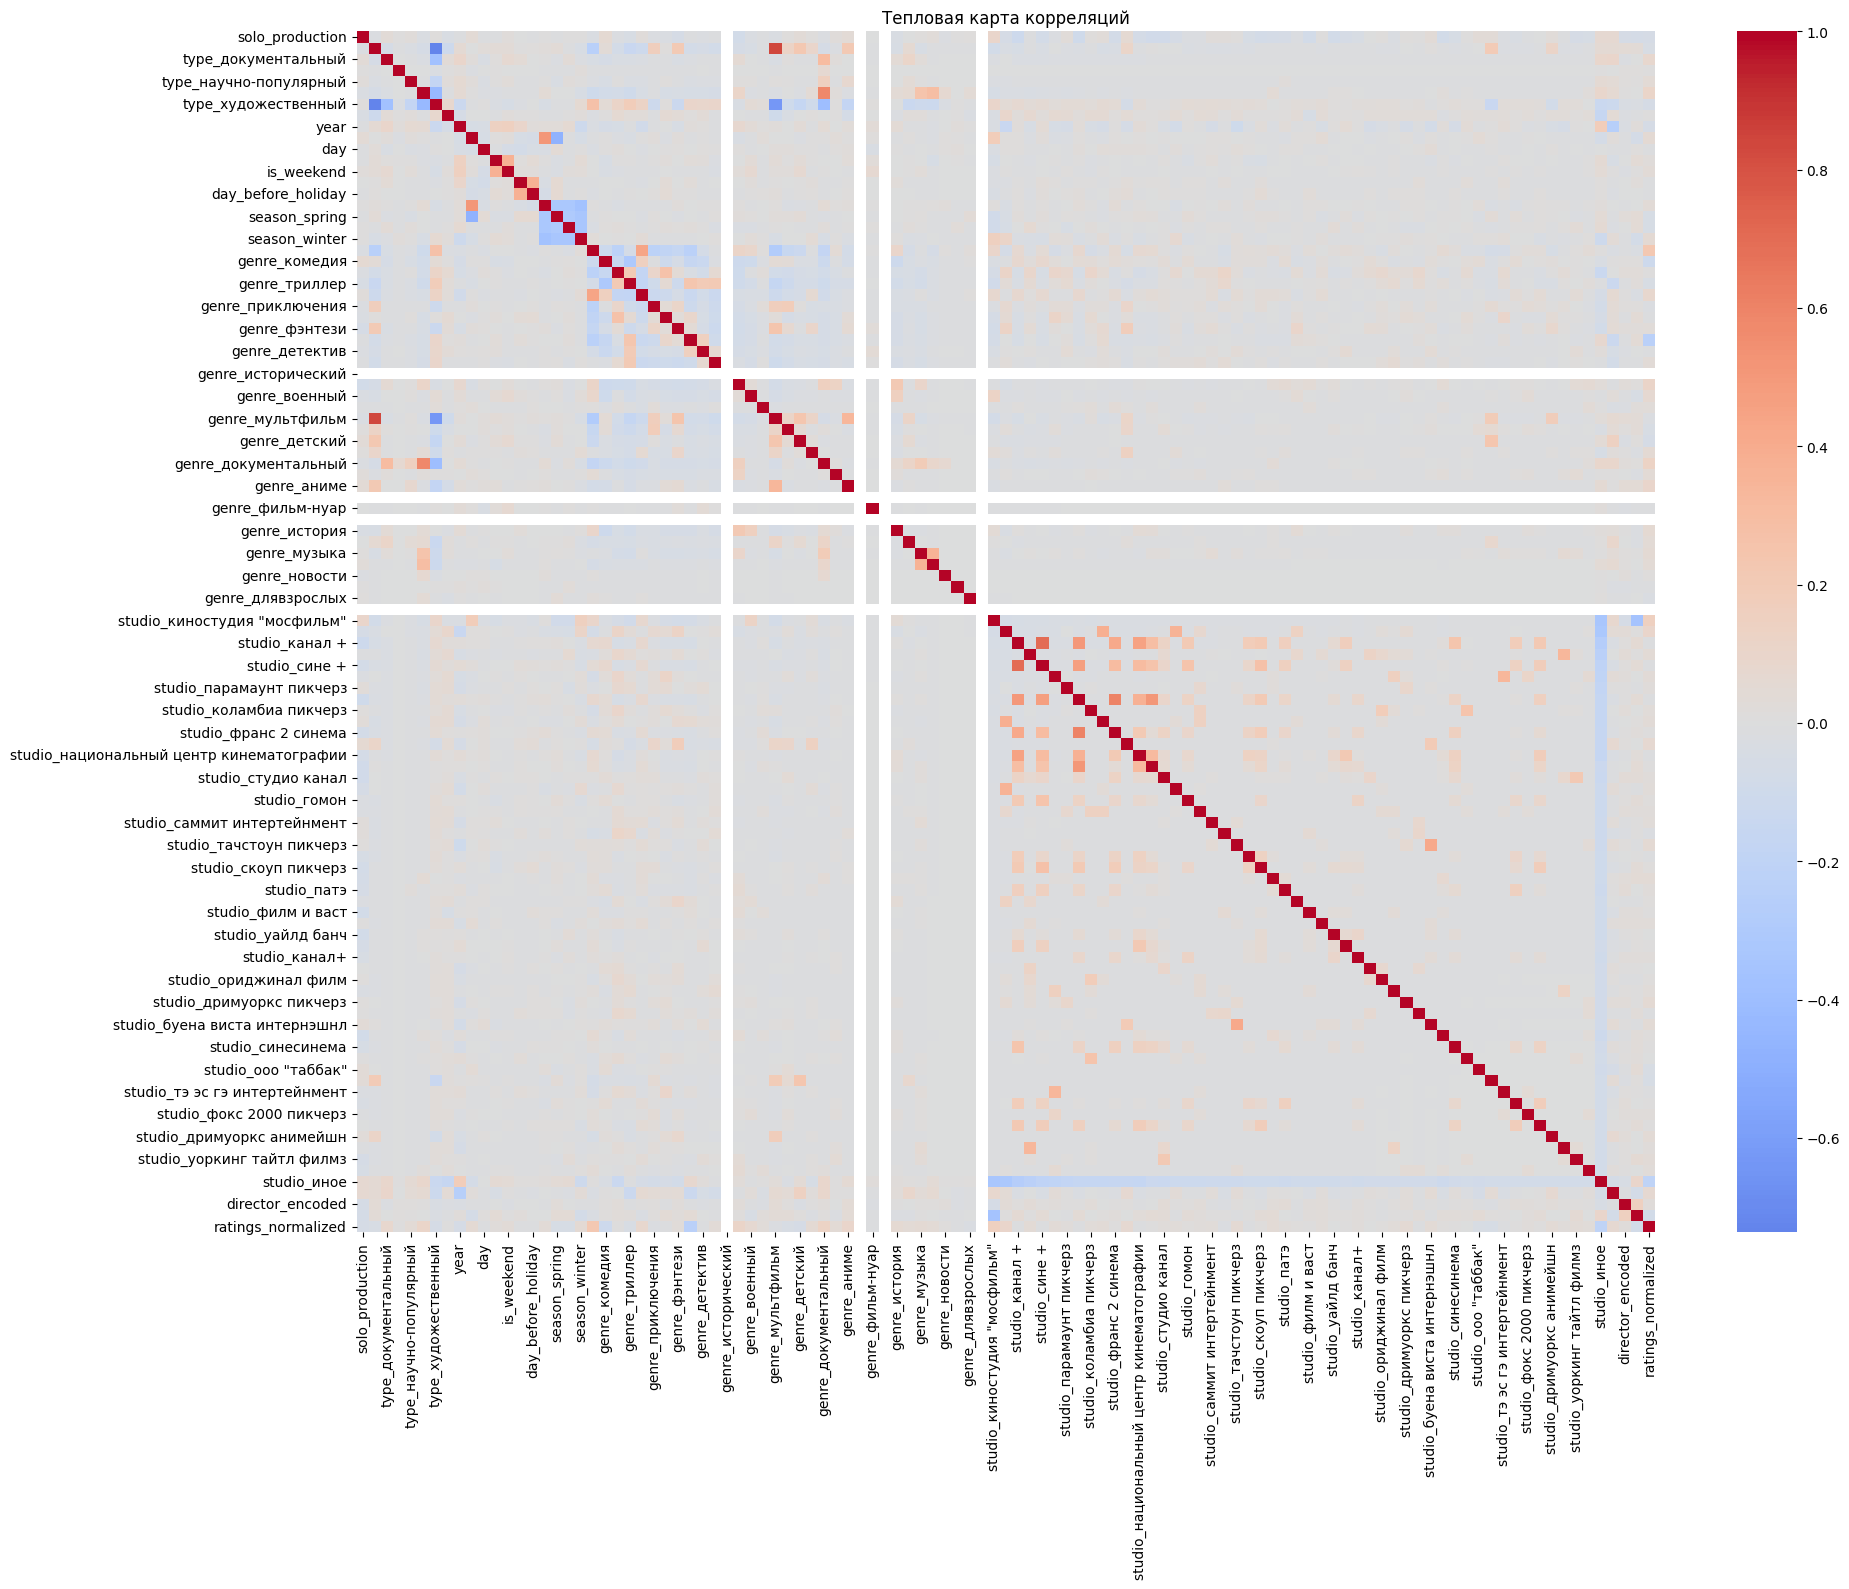

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем тепловую карту корреляций
plt.figure(figsize=(20, 16))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Тепловая карта корреляций')
plt.tight_layout()
plt.show()

Ну как то почистили и ладно

## Поделим данные и поскейлим все это дело

In [381]:
df

,solo_production,type_анимационный,type_документальный,type_музыкально-развлекательный,type_научно-популярный,type_прочие,type_художественный,production_country_encoded,year,month,...,studio_просиреп,studio_дримуоркс анимейшн,studio_рилейтивити медиа,studio_уоркинг тайтл филмз,studio_партисипант медиа,studio_иное,age_restriction_encoded,director_encoded,producer_encoded,ratings_normalized
0,1,0,0,0,0,0,1,72,2015,11,...,0,0,0,0,0,0,1,1902,1610,7.2
1,1,0,0,0,0,0,1,69,2016,9,...,0,0,0,0,0,0,0,1599,0,6.6
2,1,0,0,0,0,0,1,72,2016,10,...,0,0,1,0,0,0,1,3519,1286,6.8
5,1,0,0,0,0,0,1,69,2016,9,...,0,0,0,0,0,0,0,620,0,7.7
6,1,0,0,0,0,0,1,69,2013,10,...,0,0,0,0,0,0,3,720,0,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,1,0,0,0,0,0,1,71,2019,12,...,0,0,0,0,0,1,3,1785,3739,5.9
7477,1,0,0,0,0,0,1,67,2019,12,...,0,0,0,0,0,1,2,3269,1101,6.3
7478,1,0,0,0,0,0,1,71,2019,12,...,0,0,0,0,0,1,3,2434,3815,4.5
7482,1,0,0,0,0,0,1,72,2019,12,...,0,0,0,0,0,1,2,2628,1253,5.4


## Делим

In [382]:
from sklearn.model_selection import train_test_split

# Разделяем на признаки и целевую переменную
X = df.drop('ratings_normalized', axis=1)
y = df['ratings_normalized']

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42
)

print("Разделение завершено:")
print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

Разделение завершено:
Train: (3615, 106)
Validation: (1206, 106)
Test: (1206, 106)


In [383]:
# Инициализируем скейлер
scaler = StandardScaler()

# Обучаем скейлер на тренировочных данных
X_train_scaled = scaler.fit_transform(X_train)

# Применяем скейлер к валидации и тесту
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Почистим с помощью PCA

In [384]:
# Инициализируем PCA
pca = PCA()

# Обучаем PCA на тренировочных данных
X_train_pca = pca.fit_transform(X_train_scaled)

# Применяем PCA к валидации и тесту
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA применение завершено:")
print(f"Train PCA: {X_train_pca.shape}")
print(f"Validation PCA: {X_val_pca.shape}")
print(f"Test PCA: {X_test_pca.shape}")

PCA применение завершено:
Train PCA: (3615, 106)
Validation PCA: (1206, 106)
Test PCA: (1206, 106)


In [385]:
# Создаем компактный интерактивный график
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = range(1, len(cumulative_variance) + 1)

# Находим компоненту для 95% дисперсии
component_95 = np.argmax(cumulative_variance >= 0.95) + 1

fig = px.line(
    x=components, 
    y=cumulative_variance,
    title='Объясненная дисперсия PCA',
    labels={'x': 'Компоненты', 'y': 'Накопленная дисперсия'}
)

# Добавляем отметку для 95%
fig.add_vline(
    x=component_95, 
    line_dash="dash", 
    line_color="red",
    annotation_text=f"95%: {component_95} компонент"
)

fig.show()

In [386]:
# Оставляем только первые 85 главных компонент
n_components = 85

# Выбираем первые 85 компонент из уже преобразованных данных
X_train_pca = X_train_pca[:, :n_components]
X_val_pca = X_val_pca[:, :n_components]
X_test_pca = X_test_pca[:, :n_components]

print("Оставлены первые 85 компонент:")
print(f"Train PCA: {X_train_pca.shape}")
print(f"Validation PCA: {X_val_pca.shape}")
print(f"Test PCA: {X_test_pca.shape}")

Оставлены первые 85 компонент:
Train PCA: (3615, 85)
Validation PCA: (1206, 85)
Test PCA: (1206, 85)


In [387]:
X_train_pca

array([[-1.39292304, -1.49495894, -0.54483947, ...,  1.79610453,
        -0.96413018,  1.3184996 ],
       [-0.46435355,  1.01546231,  0.33306746, ..., -0.10717309,
         0.33022532,  0.40504237],
       [ 0.60429604,  1.11090861,  0.78189102, ..., -1.22284919,
        -0.38984513, -1.43638254],
       ...,
       [ 0.21967018,  0.62637106, -1.4355859 , ..., -0.86567007,
        -0.02937651,  1.28980788],
       [ 0.01530652,  0.82564817,  1.31912264, ...,  0.8932978 ,
         0.40383993,  0.21630864],
       [ 0.11987743,  0.71953372,  0.83068201, ...,  0.17813776,
        -0.67346544,  0.45681935]])

In [409]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


## Baseline модель

In [410]:
class BaselineNN(nn.Module):
    def __init__(self, input_size):
        super(BaselineNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.output(x)) * 9 + 1
        return x

## Функция обучения модели

In [411]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=0.001):
    model = model.to(device)

    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val.values).view(-1, 1).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_path = "best_model.pt"

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = criterion(val_pred, y_val_tensor)

        train_losses.append(epoch_loss / (len(X_train_tensor) // batch_size))
        val_losses.append(val_loss.item())

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save(model.state_dict(), best_model_path)

        if epoch % 4 == 0:
            print(f"Epoch {epoch:3d}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

    return train_losses, val_losses, best_model_path


## Функция оценки модели (RMSE)

In [412]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    model.to(device)
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        predictions = model(X_test_tensor).cpu().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse, predictions

## Создание и обучение Baseline модели

In [414]:
input_size = X_train_pca.shape[1]
baseline_model = BaselineNN(input_size)

input_size = X_train_pca.shape[1]
baseline_model = BaselineNN(input_size)

print("Архитектура модели: 64 → 32 → 1")
print(f"Входных признаков: {input_size}")

train_losses, val_losses, best_model_path = train_model(
    baseline_model,
    X_train_pca, y_train,
    X_val_pca, y_val,
    epochs=100,
    batch_size=32,
    lr=0.0001
)

# загрузка лучших весов
baseline_model.load_state_dict(torch.load(best_model_path))


Архитектура модели: 64 → 32 → 1
Входных признаков: 85
Epoch   0: Train Loss = 1.6950, Val Loss = 1.3188
Epoch   4: Train Loss = 1.0779, Val Loss = 1.0055
Epoch   8: Train Loss = 0.9839, Val Loss = 0.9578
Epoch  12: Train Loss = 0.9473, Val Loss = 0.9464
Epoch  16: Train Loss = 0.9230, Val Loss = 0.9406
Epoch  20: Train Loss = 0.9022, Val Loss = 0.9371
Epoch  24: Train Loss = 0.8826, Val Loss = 0.9352
Epoch  28: Train Loss = 0.8641, Val Loss = 0.9349
Epoch  32: Train Loss = 0.8461, Val Loss = 0.9351
Epoch  36: Train Loss = 0.8281, Val Loss = 0.9361
Epoch  40: Train Loss = 0.8105, Val Loss = 0.9383
Epoch  44: Train Loss = 0.7935, Val Loss = 0.9413
Epoch  48: Train Loss = 0.7771, Val Loss = 0.9453
Epoch  52: Train Loss = 0.7611, Val Loss = 0.9498
Epoch  56: Train Loss = 0.7453, Val Loss = 0.9553
Epoch  60: Train Loss = 0.7299, Val Loss = 0.9618
Epoch  64: Train Loss = 0.7151, Val Loss = 0.9688
Epoch  68: Train Loss = 0.7009, Val Loss = 0.9755
Epoch  72: Train Loss = 0.6869, Val Loss = 0.9

<All keys matched successfully>

## График функции потерь по эпохам

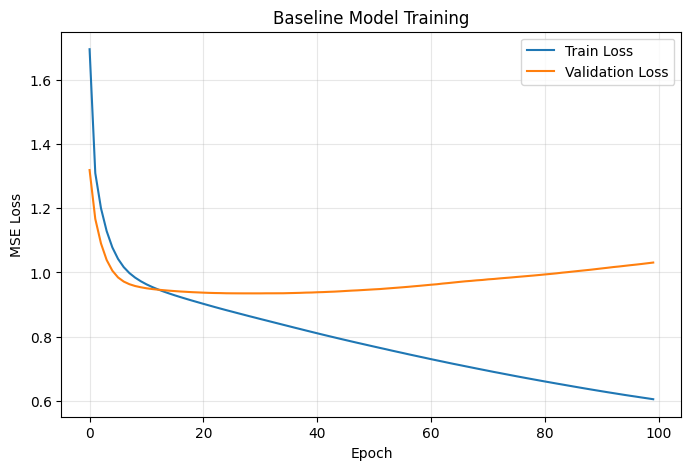

Финальная train loss: 0.6053
Финальная validation loss: 1.0308


In [415]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Baseline Model Training')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Финальная train loss: {train_losses[-1]:.4f}")
print(f"Финальная validation loss: {val_losses[-1]:.4f}")

## Оценка модели на тестовых данных

In [416]:
rmse, preds = evaluate_model(baseline_model, X_test_pca, y_test)
print(f"Лучшее val_loss = {min(val_losses):.4f}")
print(f"RMSE на тесте: {rmse:.4f}")

Лучшее val_loss = 0.9349
RMSE на тесте: 1.0037


## Класс модели с настраиваемыми параметрами

In [418]:
class TunableNN(nn.Module):
    def __init__(self, input_size, activation='ReLU', dropout=0.0, batchnorm=False):
        super(TunableNN, self).__init__()

        # выбор активации
        if activation == 'ReLU':
            self.act = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.act = nn.LeakyReLU(0.01)
        elif activation == 'ELU':
            self.act = nn.ELU()
        else:
            raise ValueError("Unknown activation")

        self.bn1 = nn.BatchNorm1d(64) if batchnorm else nn.Identity()
        self.bn2 = nn.BatchNorm1d(32) if batchnorm else nn.Identity()
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.output(x)
        x = self.sigmoid(x) * 9 + 1  # [0,1] → [1,10]
        return x

## Быстрое обучение модели для оценки

In [419]:
def train_quick(model, X_train, y_train, X_val, y_val, batch_size=32, lr=0.0005, epochs=30):
    model = model.to(device)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val.values).view(-1, 1).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            pred = model(batch_X)
            loss = criterion(pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # оценка на валидации
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = np.sqrt(mean_squared_error(y_val_tensor.cpu(), val_pred.cpu()))
            if val_loss < best_val_loss:
                best_val_loss = val_loss

    return best_val_loss

## Целевая функция для Optuna

In [420]:
def objective(trial):
    activation = trial.suggest_categorical('activation', ['ReLU','LeakyReLU','ELU'])
    dropout = trial.suggest_float('dropout', 0.0, 0.2)
    batchnorm = trial.suggest_categorical('batchnorm', [False, True])
    batch_size = trial.suggest_categorical('batch_size', [16,32,64])

    model = TunableNN(input_size=X_train_pca.shape[1], activation=activation, dropout=dropout, batchnorm=batchnorm)
    val_rmse = train_quick(model, X_train_pca, y_train, X_val_pca, y_val, batch_size=batch_size, epochs=30)
    return val_rmse

In [421]:
# --- Запуск Optuna ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # можно увеличить n_trials для более тщательного поиска

print("Лучшие параметры:", study.best_params)
print("Лучший RMSE на валидации:", study.best_value)

# --- Обучение финальной модели на найденных параметрах ---
best_params = study.best_params
final_model = TunableNN(
    input_size=X_train_pca.shape[1],
    activation=best_params['activation'],
    dropout=best_params['dropout'],
    batchnorm=best_params['batchnorm']
)

# Можно обучить на всех эпохах для финальной модели
train_losses, val_losses, best_model_path = train_model(
    final_model, X_train_pca, y_train, X_val_pca, y_val,
    epochs=100,
    batch_size=best_params['batch_size'],
    lr=0.0001
)

# загрузка лучших весов и оценка на тесте
final_model.load_state_dict(torch.load(best_model_path))
rmse_test, preds_test = evaluate_model(final_model, X_test_pca, y_test)
print("RMSE на тесте:", rmse_test)

[I 2025-11-14 00:05:27,900] A new study created in memory with name: no-name-ac0fe4a3-0999-4a88-91e5-086c08a72c6c
[I 2025-11-14 00:05:34,705] Trial 0 finished with value: 0.9709857859175166 and parameters: {'activation': 'ELU', 'dropout': 0.18734866805825115, 'batchnorm': False, 'batch_size': 32}. Best is trial 0 with value: 0.9709857859175166.
[I 2025-11-14 00:05:49,065] Trial 1 finished with value: 0.9577993930336794 and parameters: {'activation': 'ReLU', 'dropout': 0.12743444063610088, 'batchnorm': False, 'batch_size': 16}. Best is trial 1 with value: 0.9577993930336794.
[I 2025-11-14 00:05:52,819] Trial 2 finished with value: 0.969932449780943 and parameters: {'activation': 'ReLU', 'dropout': 0.02240976498358556, 'batchnorm': False, 'batch_size': 64}. Best is trial 1 with value: 0.9577993930336794.
[I 2025-11-14 00:05:59,498] Trial 3 finished with value: 0.9655720051170368 and parameters: {'activation': 'ELU', 'dropout': 0.09131267642228269, 'batchnorm': False, 'batch_size': 32}. B

Лучшие параметры: {'activation': 'LeakyReLU', 'dropout': 0.19897796058222583, 'batchnorm': False, 'batch_size': 16}
Лучший RMSE на валидации: 0.9531652098131683
Epoch   0: Train Loss = 1.7142, Val Loss = 1.2511
Epoch   4: Train Loss = 1.1255, Val Loss = 1.0087
Epoch   8: Train Loss = 1.0652, Val Loss = 0.9807
Epoch  12: Train Loss = 1.0371, Val Loss = 0.9676
Epoch  16: Train Loss = 1.0195, Val Loss = 0.9595
Epoch  20: Train Loss = 0.9994, Val Loss = 0.9503
Epoch  24: Train Loss = 0.9868, Val Loss = 0.9467
Epoch  28: Train Loss = 0.9721, Val Loss = 0.9444
Epoch  32: Train Loss = 0.9684, Val Loss = 0.9453
Epoch  36: Train Loss = 0.9519, Val Loss = 0.9450
Epoch  40: Train Loss = 0.9408, Val Loss = 0.9437
Epoch  44: Train Loss = 0.9179, Val Loss = 0.9420
Epoch  48: Train Loss = 0.9215, Val Loss = 0.9391
Epoch  52: Train Loss = 0.9015, Val Loss = 0.9377
Epoch  56: Train Loss = 0.8883, Val Loss = 0.9382
Epoch  60: Train Loss = 0.8912, Val Loss = 0.9369
Epoch  64: Train Loss = 0.8775, Val Los

/tmp/ipykernel_47841/650136484.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_47841/650136484.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_47841/650136484.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




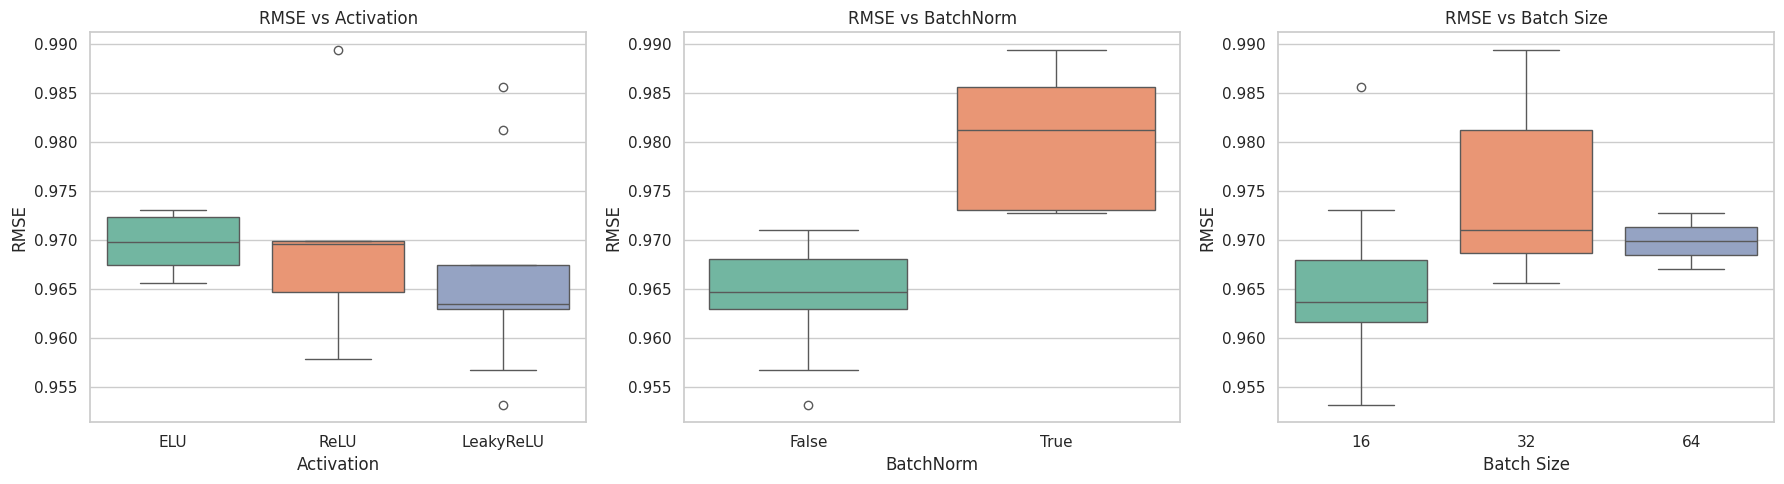

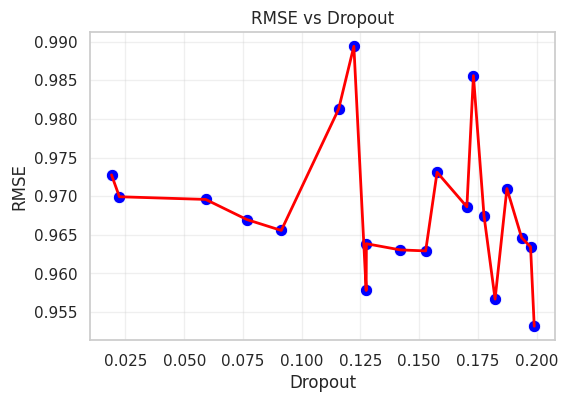

In [425]:


# Преобразуем результаты Optuna в DataFrame
trials = study.trials_dataframe()
trials = trials[['value', 'params_activation', 'params_dropout', 'params_batchnorm', 'params_batch_size']]
trials.rename(columns={'value':'RMSE'}, inplace=True)

sns.set(style="whitegrid")

# --- Boxplots для категориальных параметров ---
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(x='params_activation', y='RMSE', data=trials, ax=axes[0], palette="Set2")
axes[0].set_title('RMSE vs Activation')
axes[0].set_xlabel('Activation')
axes[0].set_ylabel('RMSE')

sns.boxplot(x='params_batchnorm', y='RMSE', data=trials, ax=axes[1], palette="Set2")
axes[1].set_title('RMSE vs BatchNorm')
axes[1].set_xlabel('BatchNorm')
axes[1].set_ylabel('RMSE')

sns.boxplot(x='params_batch_size', y='RMSE', data=trials, ax=axes[2], palette="Set2")
axes[2].set_title('RMSE vs Batch Size')
axes[2].set_xlabel('Batch Size')
axes[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

# --- Scatterplot для Dropout ---
plt.figure(figsize=(6,4))
sns.scatterplot(x='params_dropout', y='RMSE', data=trials, s=80, color='blue')
sns.lineplot(x='params_dropout', y='RMSE', data=trials.sort_values('params_dropout'), color='red', lw=2)
plt.xlabel('Dropout')
plt.ylabel('RMSE')
plt.title('RMSE vs Dropout')
plt.grid(alpha=0.3)
plt.show()



Лучшие параметры: {'activation': 'LeakyReLU', 'dropout': 0.19898, 'batchnorm': False, 'batch_size': 16}
Лучший RMSE на валидации: 0.9532


## Визуализация влияния гиперпараметров

* **Activation**: LeakyReLU показала наименьший RMSE на валидации.
* **BatchNorm**: добавление batch normalization в данной модели не улучшало качество.
* **Batch size**: меньший размер батча (16) дал лучшие результаты.
* **Dropout**: оптимальное значение около 0.2, снижает переобучение.


> На графиках видно распределение RMSE для категориальных параметров (activation, batchnorm, batch size) и зависимость RMSE от значения dropout.



## Результаты обучения модели с лучшими параметрами

* Использовали оптимальные параметры (`LeakyReLU`, `dropout=0.199`, `batchnorm=False`, `batch_size=16`).
* Обучение проводилось 100 эпох.
* RMSE на тестовой выборке: **0.9981**

### Краткое описание графиков потерь:

* Train Loss постепенно снижается, в начале более резкое падение, затем стабилизация.
* Validation Loss показывает схожую динамику, небольшие колебания указывают на умеренное переобучение.



## Вывод

1. Подбор гиперпараметров через Optuna позволил улучшить качество модели на валидации (RMSE снизился с ~0.957 до ~0.953).
2. На тесте RMSE оказался чуть выше в силу различий в распределении данных, что характерно для регрессии.
3. Наилучшие настройки: функция активации `LeakyReLU`, небольшой dropout (≈0.2), отсутствие batch normalization, маленький размер батча (16).
4. Визуализация результатов помогает понять влияние каждого гиперпараметра на качество модели и выбрать оптимальную конфигурацию.
